In [1]:
import torch

from reggae.gp.variational.models import SingleLinearLFM, ExponentialLFM
from reggae.gp.variational.trainer import Trainer
from reggae.data_loaders import load_barenco_puma, DataHolder, scaled_barenco_data
from reggae.utilities import save, load
from reggae.plot.variational_plotters import Plotter

from matplotlib import pyplot as plt
import numpy as np

f64 = np.float64

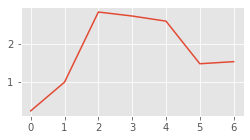

In [2]:
replicate = 0 #TODO: for now we are just considering the first replicate

m_observed, f_observed, σ2_m_pre, σ2_f_pre, t = load_barenco_puma('../data/')

m_df, m_observed = m_observed
f_df, f_observed = f_observed
# Shape of m_observed = (replicates, genes, times)
m_observed = torch.tensor(m_observed)[replicate]

σ2_m_pre = f64(σ2_m_pre)
σ2_f_pre = f64(σ2_f_pre) #not used

num_genes = m_observed.shape[0]
num_tfs = 1

t_inducing = torch.linspace(f64(0), f64(1), 5, dtype=torch.float64).reshape((-1, 1))
t_observed = torch.linspace(f64(0), f64(1), 7).view(-1)
plt.figure(figsize=(4, 2))
plt.plot(m_observed[0])

In [3]:
def plot_genes(rtol=1e-4, atol=1e-6):
    t_predict = torch.linspace(f64(0), f64(1), 80)
    initial_value = torch.zeros((num_genes, 1), dtype=torch.float64) #, dtype=torch.float64

    # output_obs, _ = model(t_observed.view(-1), initial_value, rtol=rtol, atol=atol)
    # output_obs = torch.squeeze(output_obs).detach()
    # plt.plot(t_observed, output_obs[0])
    # plt.scatter(t_observed, m_observed[0][0])

    outputs, _ = model(t_predict.view(-1), initial_value, rtol=rtol, atol=atol, num_samples=1)

    outputs = torch.squeeze(outputs)
    print(outputs.shape)
    plt.figure(figsize=(5, 8))
    for i in range(num_genes):
        plt.subplot(511+i)
        plt.plot(t_predict, torch.squeeze(outputs[i]).detach())
        plt.scatter(t_observed, m_observed[i])

In [4]:
model = ExponentialLFM(num_genes, num_tfs, t_inducing, t_observed, extra_points=2, fixed_variance=σ2_m_pre[0])
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
trainer = Trainer(model, optimizer, (t_observed, m_observed))

C:\Users\Jacob\Documents\proj\reggae\reggae\gp\variational\models.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = torch.tensor(t_inducing, requires_grad=False)


### Outputs prior to training:

C:\Users\Jacob\Documents\proj\reggae\reggae\plot\variational_plotters.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


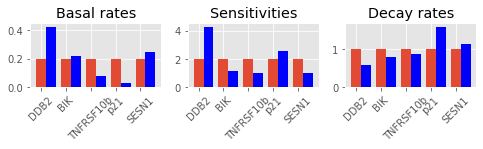

In [5]:
plotter = Plotter(model, m_df.index, t_inducing)
plotter.plot_kinetics()

torch.Size([5, 80])


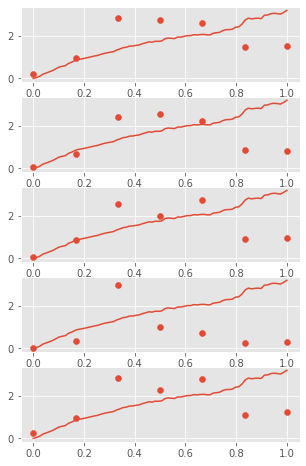

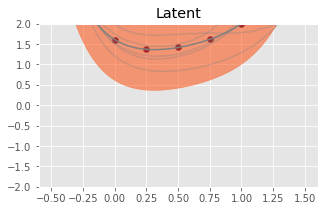

In [6]:
plot_genes(rtol=1e-3, atol=1e-4)
plotter.plot_tfs()

Epoch 51/80 - Loss: 48.02 (42.27 5.75) b: 1.50 d 2.58 s: 2.92 λ: 0.122
Epoch 53/80 - Loss: 44.11 (38.49 5.62) b: 1.52 d 2.61 s: 2.96 λ: 0.122
Epoch 55/80 - Loss: 42.16 (36.41 5.75) b: 1.55 d 2.60 s: 3.02 λ: 0.122
Epoch 57/80 - Loss: 44.94 (38.95 5.99) b: 1.60 d 2.57 s: 3.09 λ: 0.122
Epoch 59/80 - Loss: 45.33 (39.23 6.10) b: 1.63 d 2.54 s: 3.13 λ: 0.121
Epoch 61/80 - Loss: 38.47 (32.63 5.84) b: 1.64 d 2.52 s: 3.14 λ: 0.120
Epoch 63/80 - Loss: 39.71 (34.17 5.53) b: 1.66 d 2.50 s: 3.15 λ: 0.121
Epoch 65/80 - Loss: 39.23 (33.87 5.35) b: 1.68 d 2.47 s: 3.17 λ: 0.121
Epoch 67/80 - Loss: 37.95 (32.63 5.32) b: 1.70 d 2.43 s: 3.20 λ: 0.122
Epoch 69/80 - Loss: 38.61 (33.24 5.37) b: 1.72 d 2.39 s: 3.23 λ: 0.122
Epoch 71/80 - Loss: 35.01 (29.55 5.46) b: 1.72 d 2.38 s: 3.25 λ: 0.122
Epoch 73/80 - Loss: 37.96 (32.44 5.52) b: 1.72 d 2.38 s: 3.27 λ: 0.123
Epoch 75/80 - Loss: 36.24 (30.70 5.54) b: 1.70 d 2.40 s: 3.27 λ: 0.123
Epoch 77/80 - Loss: 35.19 (29.68 5.51) b: 1.67 d 2.42 s: 3.28 λ: 0.123
Epoch 

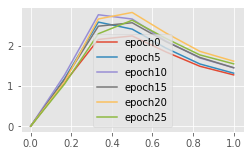

In [14]:
tol = 1e-3
# trainer = Trainer(optimizer)
output = trainer.train(30, rtol=tol, atol=tol/10,
                       report_interval=2, plot_interval=5, num_samples=4)

### Outputs after training

torch.Size([5, 80])


C:\Users\Jacob\Documents\proj\reggae\reggae\plot\variational_plotters.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


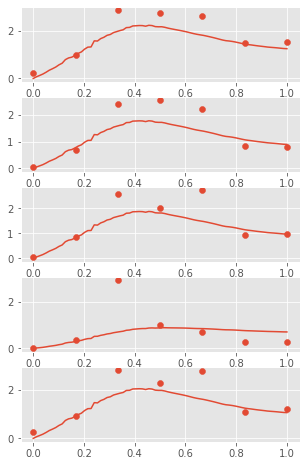

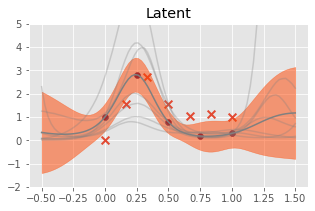

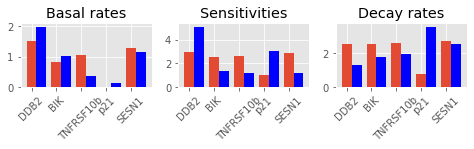

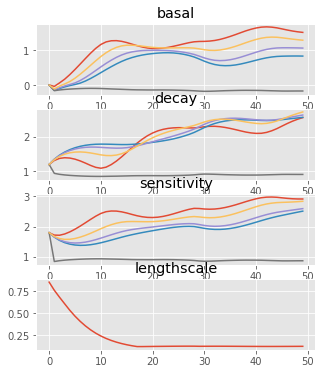

In [13]:
tol = 1e-3
plotter = Plotter(model, m_df.index, t_inducing)

# plot_losses(trainer)
plot_genes(rtol=tol, atol=tol/10)
plotter.plot_tfs(ylim=(-2, 5), plot_barenco=True)
plotter.plot_kinetics()
plotter.plot_parameters(trainer)

In [12]:
save(model, 'variational_linear')

In [15]:
model = load('variational_linear', SingleLinearLFM, num_genes, num_tfs, t_inducing, t_observed)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
trainer = Trainer(model, optimizer, (t_observed, m_observed))

C:\Users\Jacob\Documents\proj\reggae\reggae\gp\variational\models.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = torch.tensor(t_inducing, requires_grad=False)


RuntimeError: Error(s) in loading state_dict for SingleLinearLFM:
	Missing key(s) in state_dict: "raw_likelihood_variance". 

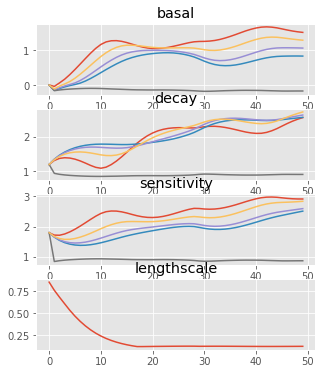